# Project Phase 1: Cats and Dogs Object Detection

## Project Abstract

In this phase, our main goal was to understand the data, construct baseline models to predict classes and detect bounding boxes on the image, and test different classification and regression models to achieve improvement over our baseline models. We used MSE, CXE and Accuracy metrics to evaluate our models.Due to large size of the dataset, we performed experiments with multiple models using subsets of the datasets. We used Linear Regression, Logistic Regression, KNN, Naive Bayes, SVC, SGD and Random Forest models. We performed Grid Search to find the best parameters and performed cross-fold validation for hyper-parameter tuning. Our results show that SVC obtained the highest accuracy of 60.83% which is higher than the baseline accuracy which was 52.7%. We also tried filtering the dataset by removing truncated, occluded, and depicted, and found our accuracy to be more than 70%, although only around 1000 images remained.

## Project Description

The purpose of this project is to create an end-to-end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

## Data Description

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). The dataset to be used is a subset of Open Images Dataset V6. It contains a total of 12,993 images, which contains about 53% dog images and 47% cat images. Image bounding boxes are stored in the csv file `cadod.csv`. The bounding bex data indicate the position of the cat or dog in the image. This information includes the coordinates for the bounding boxes, the class of the image, and information on how the bounding boxes were made. It also contains various attributes about the image such as whether the image is occluded or truncated, or whether the image is a depiction of something or taken from inside an object.


The definitions of interested attributes:
* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.
* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

## Phase 1 tasks
* Grab data, EDA, metrics, baseline models (baseline pipeline PLEASE) and a brief report
   * A starter notebook is available in the github repo.
* SKLearn digit detector pipeline
   * Feature engineering + hyperparameter tuning; in pipeline form
   * Build an SKLearn model for image classification and another model for regression (with 4 target values [y_1, y_2, y_3, y_4] corresponding to [x, y, w, h] of the bounding box containing the object of interest).
   * Hint: use from sklearn.linear_model import LinearRegression
* Homegrown digit detector pipeline 
   * Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function where the resulting model predicts the class and bounding box coordinates at the same time
* PyTorch digit detector pipeline [Stretch goal]
   * Build an PyTorch model for image classification (using a multilayer perceptron (MLP))
   * Build another PyTorch model for regression  (using a multilayer perceptron (MLP)) with 4 target values [y_1, y_2, y_3, y_4] corresponding to [x, y, w, h] of the bounding box containing the object of interest).
   * Stretch-stretch goal: build a multi-headed cat-dog detector using the OOP API in PyTorch  with a combined loss function:CXE + MSE.
* Report results
   * Report and short video presentation (2 minute video presentation; 300 words)
   * Post your presentation (video and slides) on the Canvas discussion board

## Project pipeline

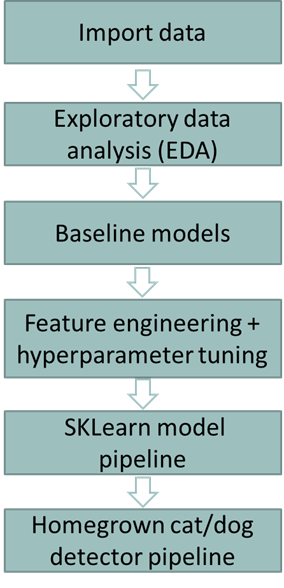

# Import Data

In [ ]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings
import pickle
import tensorflow as tf
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from numpy import arange
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unarchive image data

In [ ]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [ ]:
path = 'images/'

extract_tar('cadod.tar.gz', path)

  0%|          | 0/25936 [00:00<?, ?it/s]

Files already exist


## Load bounding box meta data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv')
df

ImageID  Source  LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0      0000b9fcba019d36  xclick  /m/0bt9lr  ...  0.506667  0.998333  0.661667
1      0000cb13febe0138  xclick  /m/0bt9lr  ...  0.410882  0.999062  0.999062
2      0005a9520eb22c19  xclick  /m/0bt9lr  ...  0.226296  0.998736  0.305942
3      0006303f02219b07  xclick  /m/0bt9lr  ...  0.375294  0.720000  0.998824
4      00064d23bf997652  xclick  /m/0bt9lr  ...  0.370000  0.424286  0.694286
...                 ...     ...        ...  ...       ...       ...       ...
12961  ffc65ce637cbd73d  xclick   /m/01yrx  ...  0.685000  0.999167  0.995000
12962  ffd1e6a91d92bf83  xclick   /m/01yrx  ...  0.005000  0.261667  0.303333
12963  ffe91ea1debeefb3  xclick   /m/01yrx  ...  0.327416  0.624260  0.358974
12964  ffebb214b9df34aa  xclick   /m/01yrx  ...  0.037523  0.560976  0.999062
12965  fffcbea446a0b7b9  xclick   /m/01yrx  ...  0.370861  0.947020  0.835541

[12966 rows x 21 columns]

# Exploratory Data Analysis

Tasks:

1. Statistics of the data
2. Visualization of images
3. Distribution analysis of image shape and size



## Statistics of the data



1.   Counts of images in different groups (cat/dog, IsOccluded, IsTruncated, IsGrouped, IsDepiction)
2.   Descriptive statistics of bounding box data (mean, std, range)



In [ ]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [ ]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 4.096 MB


In [ ]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [ ]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

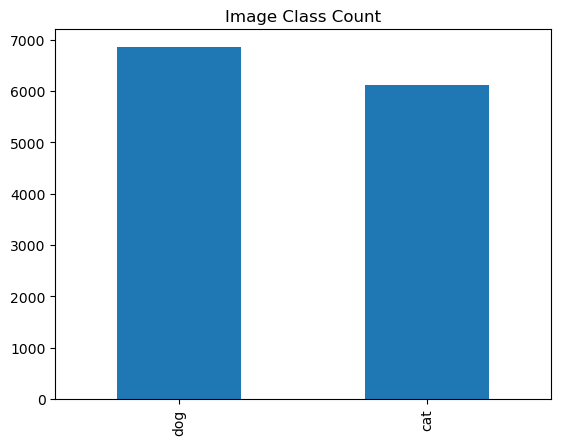

In [ ]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [ ]:
# count images which are occluded by another object in the image
df['IsOccluded'].value_counts()

 0    6934
 1    6029
-1       3
Name: IsOccluded, dtype: int64

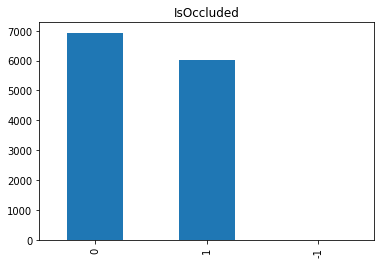

In [ ]:
df.IsOccluded.value_counts().plot(kind='bar')
plt.title('IsOccluded')
plt.show()

In [ ]:
# count images which extend beyond the boundary of the image.
df['IsTruncated'].value_counts()

 1    9578
 0    3385
-1       3
Name: IsTruncated, dtype: int64

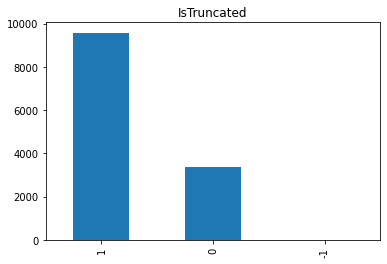

In [ ]:
df.IsTruncated.value_counts().plot(kind='bar')
plt.title('IsTruncated')
plt.show()

In [ ]:
# count images in which the box spans a group of objects
df['IsGroupOf'].value_counts()

 0    12783
 1      180
-1        3
Name: IsGroupOf, dtype: int64

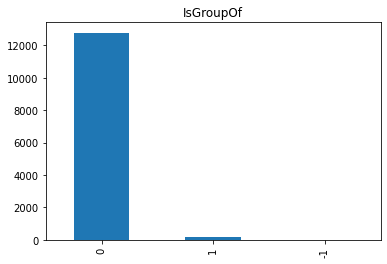

In [ ]:
df.IsGroupOf.value_counts().plot(kind='bar')
plt.title('IsGroupOf')
plt.show()

In [ ]:
# count images which is a cartoon or drawing of the object, not a real physical instance
df['IsDepiction'].value_counts()

 0    12371
 1      592
-1        3
Name: IsDepiction, dtype: int64

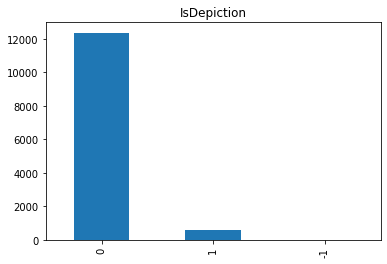

In [ ]:
df.IsDepiction.value_counts().plot(kind='bar')
plt.title('IsDepiction')
plt.show()

In [ ]:
# count images which are taken from the inside of the object
df['IsInside'].value_counts()

 0    12945
 1       18
-1        3
Name: IsInside, dtype: int64

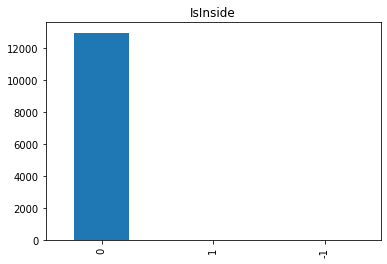

In [ ]:
df.IsInside.value_counts().plot(kind='bar')
plt.title('IsInside')
plt.show()

In [ ]:
# get the mean, std, range of bounding box data
df.describe()

Confidence          XMin  ...      XClick3Y      XClick4Y
count     12966.0  12966.000000  ...  12966.000000  12966.000000
mean          1.0      0.099437  ...      0.641749      0.582910
std           0.0      0.113023  ...      0.448054      0.403454
min           1.0      0.000000  ...     -1.000000     -1.000000
25%           1.0      0.000000  ...      0.405817      0.400000
50%           1.0      0.061250  ...      0.825000      0.646667
75%           1.0      0.167500  ...      0.998042      0.882500
max           1.0      0.592500  ...      1.000000      0.999375

[8 rows x 18 columns]

Results: 

1. There are a total of 12966 images and the total size is 844.512 MB. In these images, 6855 are from dog and 6111 are from cat. 
2. Almost half of the images are occluded by another object in the image. There are 9578 images which extend beyond the boundary of the images. There are 180 images in which the box spans a group of objects. There are 592 images in which the box spans a group of objects. 
2. Descriptive statistics of bounding box data (mean, std, range):
    *   mean   0.099437	0.901750	0.088877	0.945022
    *   std    0.113023	0.111468	0.097345	0.081500
    *   min    0.000000	0.408125	0.000000	0.451389
    *   max    0.592500	1.000000	0.587088	1.000000


## Visualization of images

Randomly plot 6 images from dataset.

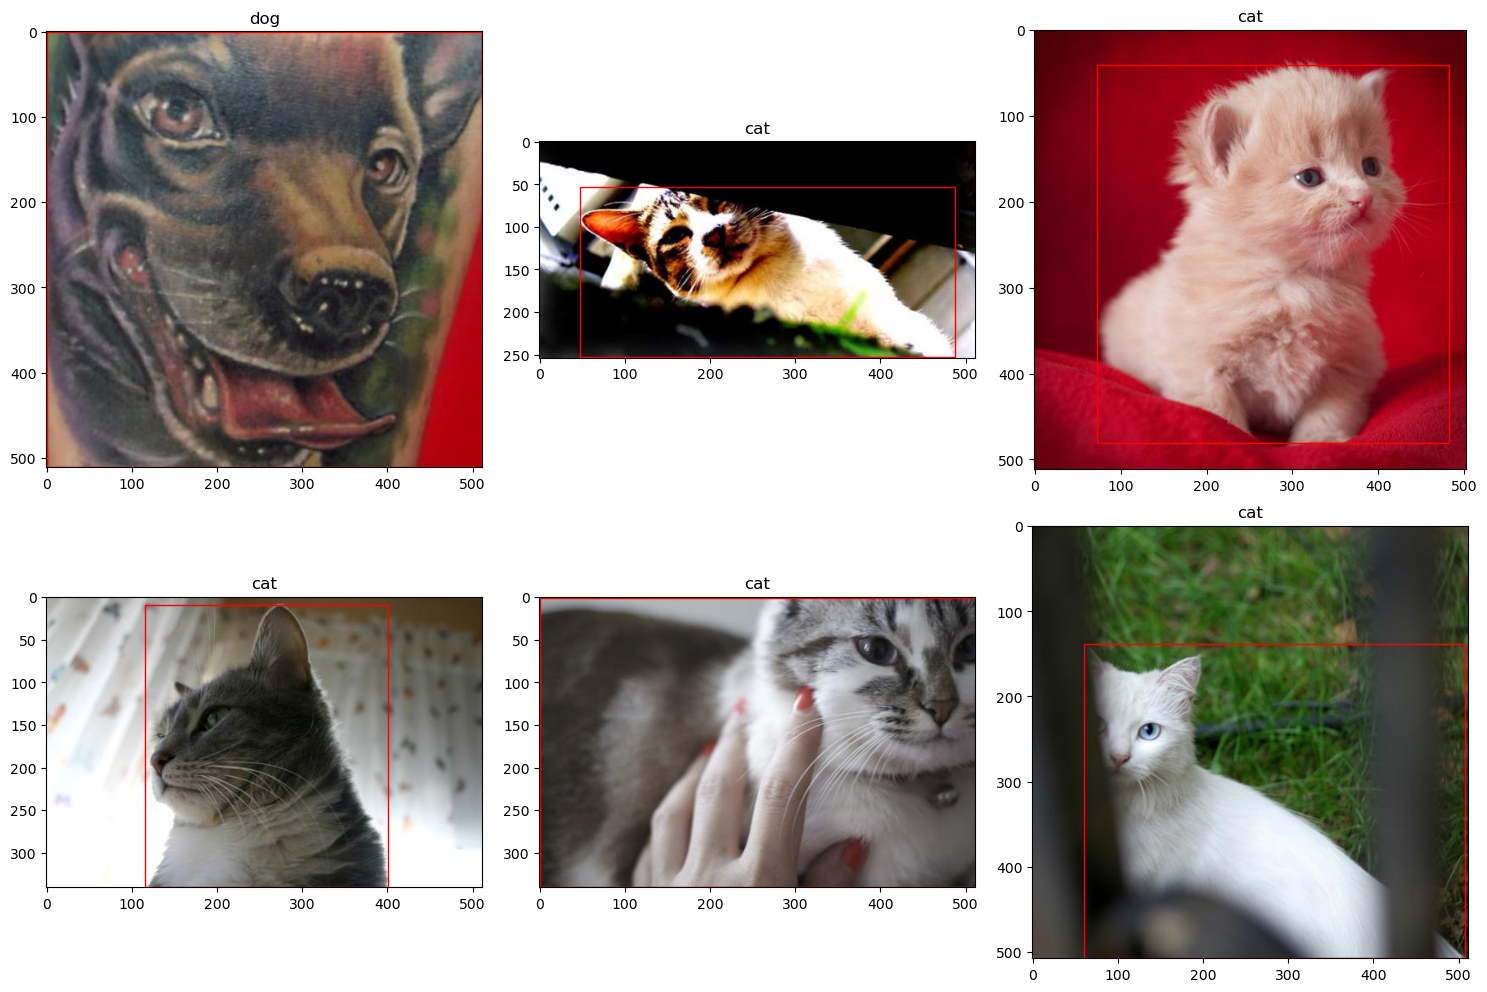

In [ ]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

Results: 


1.   Images are different in shapes.
2.   Some objects(cat/dog) are occluded or truncated.




## Distribution of image shape and size

1. Distribution of image shapes
2. Distribution of image sizes

### Get information of image shapes and sizes

In [ ]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    img_size[i] += os.path.getsize(file)

  0%|          | 0/12966 [00:00<?, ?it/s]

### Distribution of image shapes

In [ ]:
img_shape_count = Counter(img_shape)
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])
img_df.shape

(594, 2)

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a cout less than 100 and put that in a category called `other`

In [ ]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [ ]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [ ]:
img_df.img_count.sum() == df.shape[0]

True

Plot image counts whith different shapes

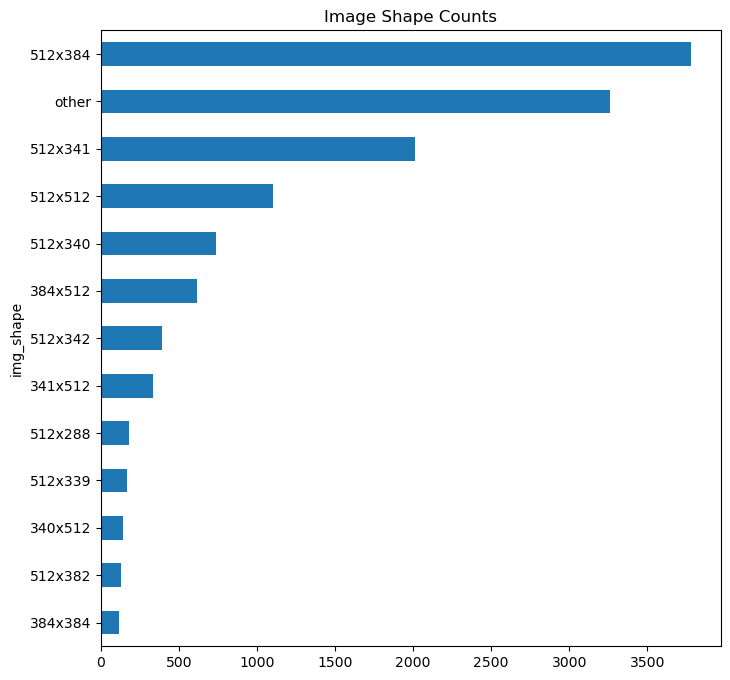

In [ ]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

### Distribution of image sizes

In [ ]:
# convert to megabytes
img_size = img_size / 1000

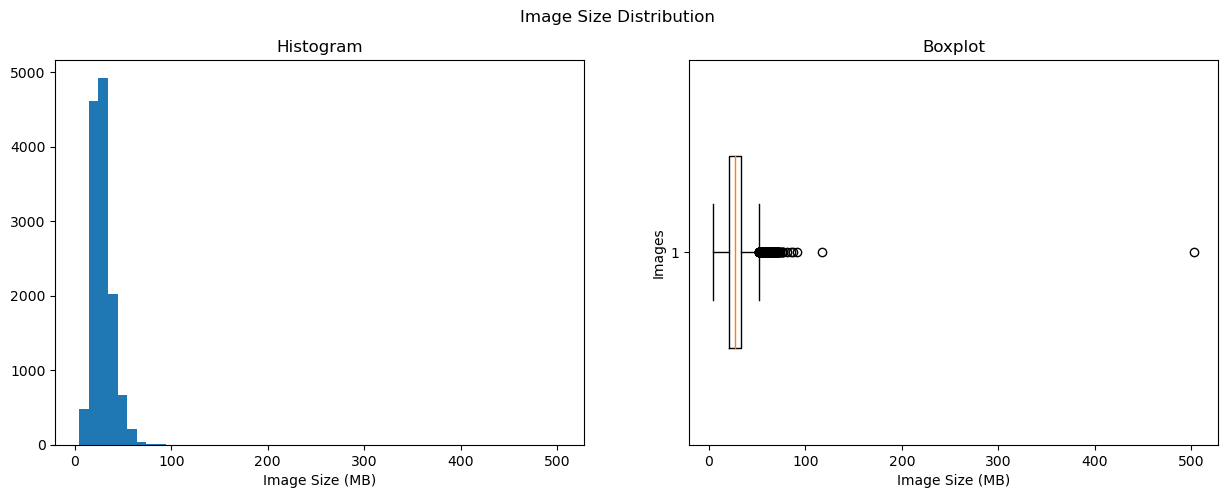

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

Results:

1. Distribution of image shapes shows that they vary from 384X384 to 512X384. 
2. Sizes of images are normally distributed.



# Preprocess

1. Rescale the images into the size of 128X128X3
2. Encode image labels
3. Save image data and bounding box data into numpy array
4. load and check the datasets



## Rescale the images

In [ ]:
!mkdir -p images/resized

In [ ]:
# rescale images
%%time
img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 2min 41s, sys: 7.59 s, total: 2min 49s
Wall time: 5min 48s


Plot the resized and filtered images

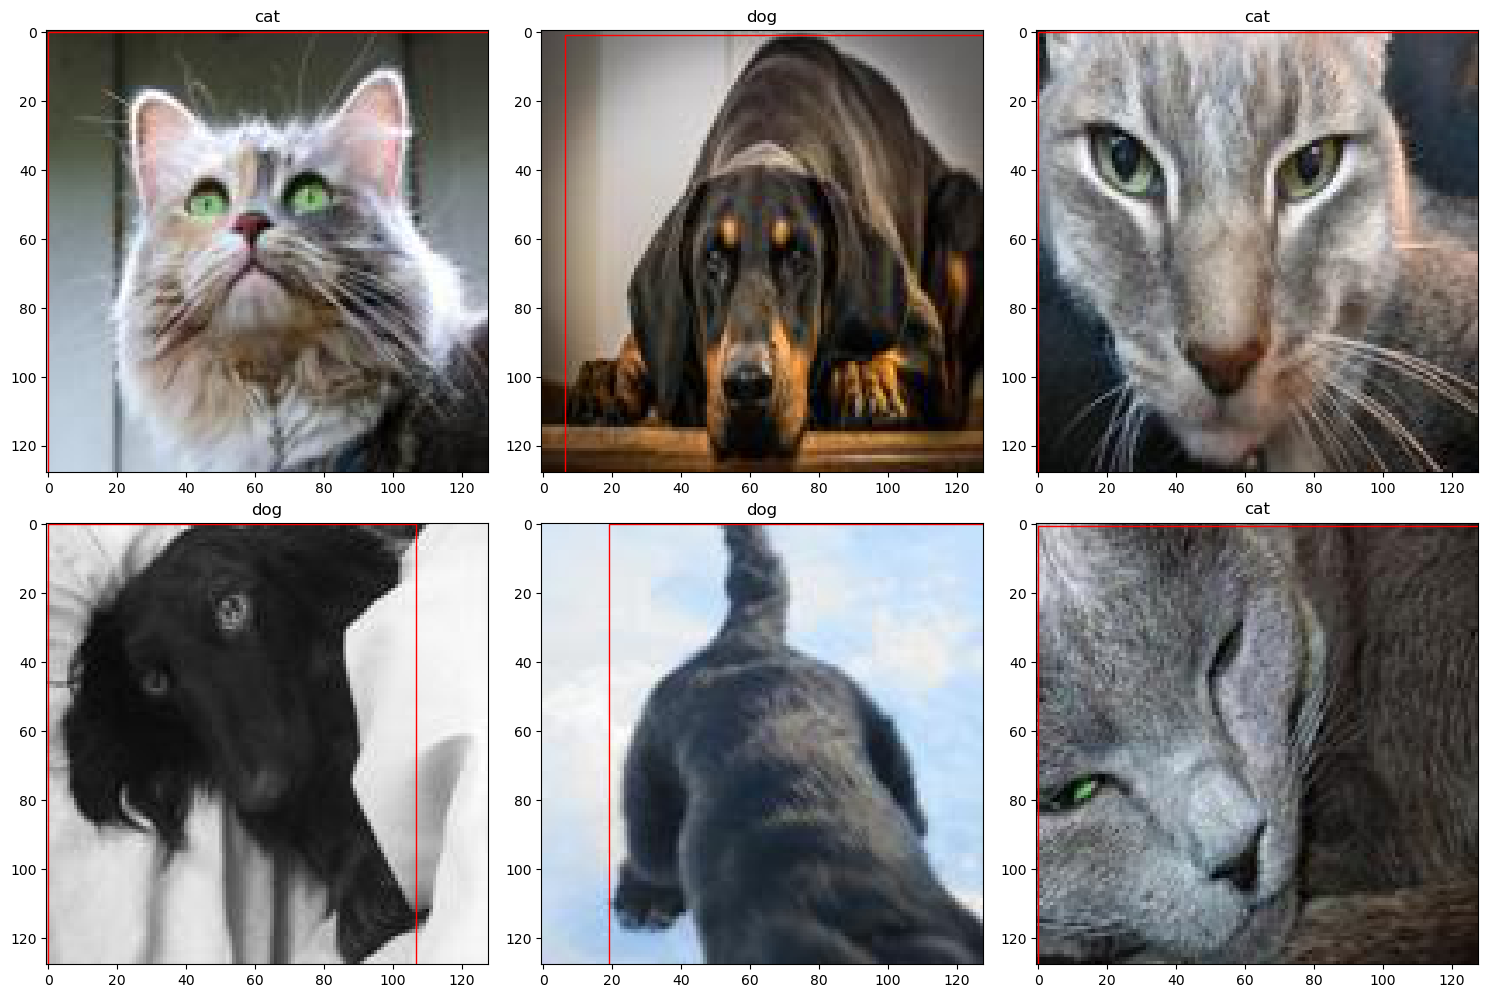

In [ ]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Encode image labels into numbers

In [ ]:
# encode labels (dog:1, cat:0)
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Save data into numpy array

In [ ]:
mkdir -p data

np.save('data/img.npy', img_arr.astype(np.uint8))
np.save('data/y_label.npy', df.Label.values)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

## Load data and check datasets

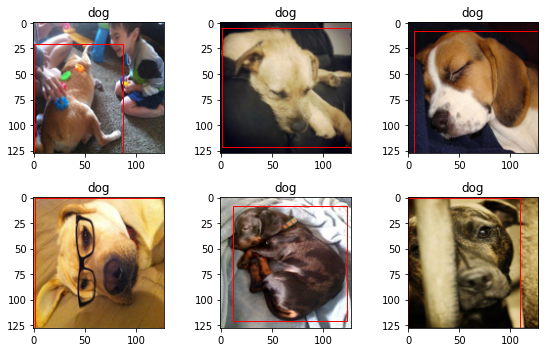

In [ ]:
# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Double check that it loaded correctly by plotting random 6 images 
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(8,5))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

# SKLearn modeling pipelines

## Machine algorithms

Image classification refers to the labeling of images into one of the classes. To predict image labels, we plan to perform several experiments with these classifier algorithms for various combinations of hyper-parameters using GridSearchCV with cross-validation. Because bounding boxes data are continuous values, we need to use regression models (linear regression and SGD regressor) for object detection. 

List of machine learning algorithms that we plan to implement:

*	Logistic Regression
*	K Nearest Neighbors Classifier
*	Support Vector Classifier
*	SGD Classifier
*	Random Froest Classifier
*	Naive Bayes Classifier
*	Linear regression
*	SGD regression

## Loss functions

The best model would be selected based on the performance on the test dataset. For the SGD classifier, we will use log loss function (aka logistic loss or cross-entropy loss). We will use mean squared error for loss function of regression models. Regularization can be used to discourage learning a more complex or flexible model, so as to avoid the risk of overfitting. We can use Ridge and Lasso to regulize the loss functions.

List of loss functions:

CXE:


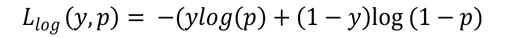


MSE:


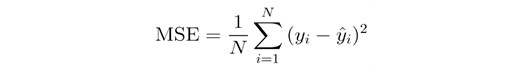


Ridge MSE:

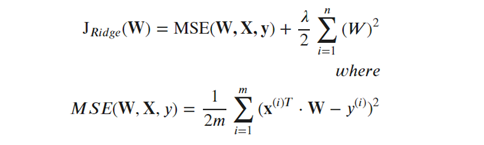

Lasso MSE:

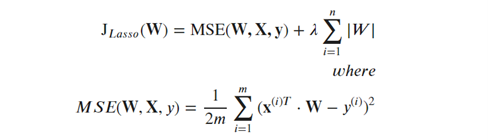


##  Evaluation metrics for classification and regression

For classification evaluation, accuracy, average precision, confusion matrix, log loss and auc score are widely used. In our project, we will use accuracy and average precision to evaluate our classification models. Accuracy is defined as the number of correct predictions divided by the total number of predictions. We will import the accuracy_score function from the metrics class and determine the accuracy of our models by passing the ground truth and predicted labels. 
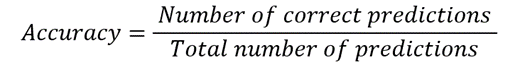


For regression models, people often use mean squared error (MSE), mean absolute error (MAE), root mean squared error (RMSE) and mean absolute percentage error (MAPE). We will use Mean Squared Error (MSE) to evaluate our regression models. By using MSE, we will find the average of the squared difference between the target value and the value predicted by the regression model. By import mean_squared_error from sklearn.metrics, we can determine the MSE regression loss by passing the ground truth and predicted values.


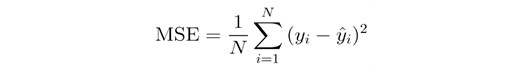

## Modeling pipelines

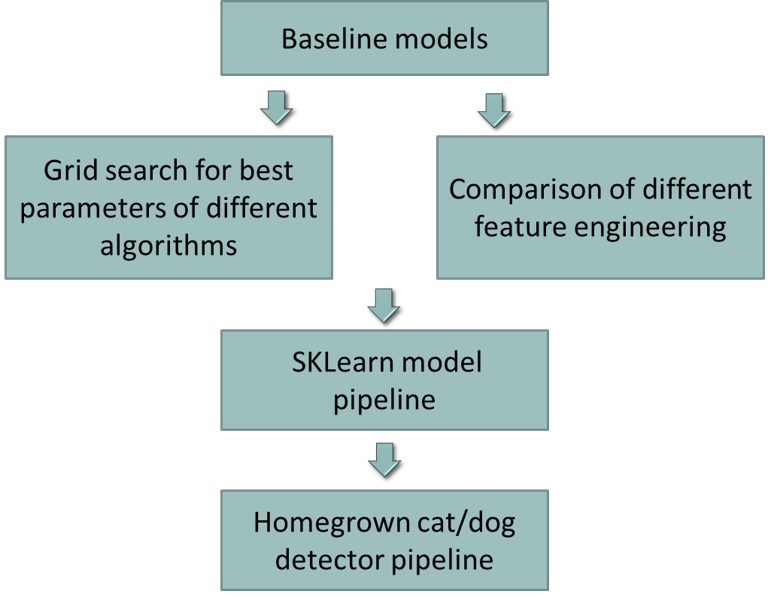

## Comparison of different algorithms

We make conparisons of different algorithms for both classification and regression models to have a briefly look over model perfermances.

### For classification models

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.581692 (0.086935)
LDA: 0.545846 (0.095748)
KNN: 0.515385 (0.105897)
CART: 0.583231 (0.103776)
NB: 0.546923 (0.054189)
SVM: 0.606308 (0.090258)
SGDC: 0.612462 (0.106946)


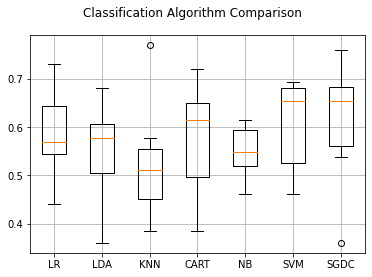

CPU times: user 3min 8s, sys: 36.8 s, total: 3min 45s
Wall time: 2min 48s


In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# subsampling
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.01)
np.random.seed(42)
subsample_rate = 0.02
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test_label, stratify=y_test_label, train_size=subsample_rate, random_state=42)

# compare different classification models
%%time
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('SGDC', SGDClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)                        
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()

**Results:**

Above we produced a box and whisker plot showing the spread of the accuracy scores across each cross-validation fold for each algorithm.

From these results, it would suggest that SGDClassifier has highest accuracy and will be used for further study on this problem.

### For regression models

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Linear: -0.019657 (0.000914)
Ridge: -0.019657 (0.000914)
Lasso: -0.010318 (0.000642)
ElasticNet: -0.010194 (0.000672)


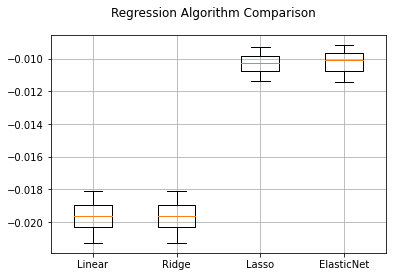

In [ ]:
# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split data to generate train, test and valid data
X_train, X_test, y_train, y_test_label = train_test_split(X, y_bbox, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# compare different regression models
with tf.device('/device:GPU:0'):

  %%time
  models = []
  models.append(('Linear', LinearRegression()))
  models.append(('Ridge', Ridge()))
  models.append(('Lasso', Lasso()))
  models.append(('ElasticNet', ElasticNet()))

  # evaluate each model in turn
  results = []
  names = []

  for name, model in models:
      kfold = KFold(n_splits=10, shuffle=True, random_state=7)
      cv_results = cross_val_score(model, X_test, y_test_label, cv=kfold, scoring='neg_mean_squared_error')                        
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

  # boxplot algorithm comparison
  fig = pyplot.figure()
  fig.suptitle('Regression Algorithm Comparison')
  ax = fig.add_subplot(111)
  pyplot.boxplot(results)
  ax.set_xticklabels(names)
  pyplot.grid()
  pyplot.show()

Lasso and ElasticNet models showed better performances than linear and Ridge regression models.

# SKLearn cat/dog detector pipeline modeling

## Image classification modeling

### Hyperparameter tuning and classification algorithms comparison

We build a baseline classification model and use GridSearch to find best parameters for different models. We compare the model performances to determine which model we can use for further modeling.

#### Define functions and load data

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from scipy import stats

# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

# TTest function
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split data to generate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.1, random_state=27)
# subset of image data
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=27)

#### Baseline logistic regression model

In [ ]:
# Baseline logistic regression model
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        #("preparation", full_pipeline),
        ("linear", LogisticRegression(random_state=42))
    ])

with tf.device('/device:GPU:0'):

  start = time()
  full_pipeline_with_predictor.fit(X_train, y_train)
  np.random.seed(42)

  # Set up cross validation scores, Use ShuffleSplit() with 3 splits, 30% test_size 
  cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
  logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits)  

  logit_score_train = logit_scores.mean()
  train_time = np.round(time() - start, 4)

  # Time and score test predictions
  start = time()
  logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
  test_time = np.round(time() - start, 4)

results.loc[0] = ["Baseline", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results


ExpID  ...      Experiment description
0  Baseline  ...  Untuned LogisticRegression

[1 rows x 7 columns]

#### Grid search for best parameters with different classification algorithms

In [ ]:
# Grid search best parameters and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier(random_state=42)),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        #("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv30Splits)
        best_train_accuracy = pct(best_train_scores.mean())
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()                                            
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [ ]:
with tf.device('/device:GPU:0'):
  %%time
  ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  n_jobs=-1, verbose=1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs
****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.6min finished


Best Parameters:
	predictor__C: 10
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 2
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 31.5min finished


Best Parameters:
	predictor__C: 10
	predictor__degree: 1
	predictor__kernel: rbf
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 79.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 83.4min finished


Best Parameters:
	predictor__alpha: 0.0001
	predictor__loss: hinge
	predictor__penalty: elasticnet
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 922 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1922 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 10.9min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 26
	predictor__max_features: 3
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 300
****** FINISH Best Model: RandomForest  *****



In [ ]:
results

ExpID  ...                             Experiment description
0                        Baseline  ...                         Untuned LogisticRegression
1  Best Model:Logistic Regression  ...  [["predictor__C", 10], ["predictor__penalty", ...
2  Best Model:K-Nearest Neighbors  ...  [["predictor__n_neighbors", 11], ["predictor__...
3          Best Model:Naive Bayes  ...                                                 []
4       Best Model:Support Vector  ...  [["predictor__C", 10], ["predictor__degree", 1...
5        Best Model:Stochastic GD  ...  [["predictor__alpha", 0.0001], ["predictor__lo...
6         Best Model:RandomForest  ...  [["predictor__bootstrap", false], ["predictor_...

[7 rows x 7 columns]

#### Results

1. SVC has the best cross fold train accurary (56.2%). However, the train time is too long to train the model.
2. LogisticRegression, RandomForest, and Naive Bayes has a relatively better performances and less time-consuming. We will use these algorithms for further modeling.

### Feature engineering comparison using logistic regression

We try to determine which transformation methods perform best with logistic regression.

1. Standardize features by removing the mean and scaling to unit variance.
2. Normalize samples individually to unit norm.
3. MinMaxScaler transform features by scaling each feature to a given range.



#### Define functions and load data

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from scipy import stats

# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

# TTest function
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split data to generate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.5, random_state=27)
# subset of image data
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=27)

#### No feature engineering with baseline logistic regression

In [ ]:
# No feature engineering with baseline logistic regression

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        #("StandardScaler", StandardScaler()),
        ("linear", LogisticRegression(random_state=42))
    ])

with tf.device('/device:GPU:0'):

  start = time()
  full_pipeline_with_predictor.fit(X_train, y_train)
  np.random.seed(42)

  # Set up cross validation scores, Use ShuffleSplit() with 3 splits, 30% test_size 
  cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
  logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits)  

  logit_score_train = logit_scores.mean()
  train_time = np.round(time() - start, 4)

  # Time and score test predictions
  start = time()
  logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
  test_time = np.round(time() - start, 4)

results.loc[0] = ["Baseline", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "With no feature engineering"]
results


ExpID  ...       Experiment description
0  Baseline  ...  With no feature engineering

[1 rows x 7 columns]

#### StandardScaler with baseline logistic regression

In [ ]:
# StandardScaler with baseline Logistic Regression 

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("StandardScaler", StandardScaler()),
        ("linear", LogisticRegression(random_state=42))
    ])

with tf.device('/device:GPU:0'):

  start = time()
  full_pipeline_with_predictor.fit(X_train, y_train)
  np.random.seed(42)

  # Set up cross validation scores, Use ShuffleSplit() with 30 splits, 30% test_size 
  cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
  best_train_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits)  

  best_train_scores_train = best_train_scores.mean()
  train_time = np.round(time() - start, 4)

  # Time and score test predictions
  start = time()
  best_train_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
  test_time = np.round(time() - start, 4)

  # Conduct t-test with baseline logit (control) and best estimator (experiment)
  (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

results.loc[1] = ["Baseline", pct(best_train_scores_train), np.round(pct(best_train_score_test),3), 
                  round(p_value,5), train_time, test_time, "With StandardScaler"]
results


ExpID  ...       Experiment description
0  Baseline  ...  With no feature engineering
1  Baseline  ...          With StandardScaler

[2 rows x 7 columns]

#### Normalier with baseline logistic regression

In [ ]:
# Normalizer with baseline Logistic Regression 

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("Normalizer", Normalizer()),
        ("linear", LogisticRegression(random_state=42))
    ])

with tf.device('/device:GPU:0'):

  start = time()
  full_pipeline_with_predictor.fit(X_train, y_train)
  np.random.seed(42)

  # Set up cross validation scores, Use ShuffleSplit() with 30 splits, 30% test_size 
  cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
  best_train_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits)  

  best_train_scores_train = best_train_scores.mean()
  train_time = np.round(time() - start, 4)

  # Time and score test predictions
  start = time()
  best_train_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
  test_time = np.round(time() - start, 4)

  # Conduct t-test with baseline logit (control) and best estimator (experiment)
  (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

results.loc[2] = ["Baseline", pct(best_train_scores_train), np.round(pct(best_train_score_test),3), 
                  round(p_value,5), train_time, test_time, "With Normalizer"]
results

ExpID  ...       Experiment description
0  Baseline  ...  With no feature engineering
1  Baseline  ...          With StandardScaler
2  Baseline  ...              With Normalizer

[3 rows x 7 columns]

#### MinMaxScaler with baseline logistic regression

In [ ]:
# MinMaxScaler with baseline Logistic Regression 

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("MinMaxScaler", MinMaxScaler(feature_range=(-1, 1))),
        ("linear", LogisticRegression(random_state=42))
    ])

with tf.device('/device:GPU:0'):

  start = time()
  full_pipeline_with_predictor.fit(X_train, y_train)
  np.random.seed(42)

  # Set up cross validation scores, Use ShuffleSplit() with 30 splits, 30% test_size 
  cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
  best_train_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits)  

  best_train_scores_train = best_train_scores.mean()
  train_time = np.round(time() - start, 4)

  # Time and score test predictions
  start = time()
  best_train_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
  test_time = np.round(time() - start, 4)

  # Conduct t-test with baseline logit (control) and best estimator (experiment)
  (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

results.loc[3] = ["Baseline", pct(best_train_scores_train), np.round(pct(best_train_score_test),3), 
                  round(p_value,5), train_time, test_time, "With MinMaxScaler"]
results

ExpID  ...       Experiment description
0  Baseline  ...  With no feature engineering
1  Baseline  ...          With StandardScaler
2  Baseline  ...              With Normalizer
3  Baseline  ...            With MinMaxScaler

[4 rows x 7 columns]

#### Results



1. Normalier has the highest test accuracy compared to baseline (test accuracy is 55.7%, p value is 0.02514).

2. StandardScaler and MinMaxScaler have similar test accuracy compared to baseline (52.7% and 53.2% compared to 53.4%).

3. We will use Normalier for further modeling.



### SKLearn model for image classification using Normalizer

We choose LogisticRegression, RandomForest, and Naive Bayes because they have relatively better test accuracy and better time consuming. We combine LogisticRegression, RandomForest, and Naive Bayes with Normalier for SKLearn pipeline modeling. 

#### Load data

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

# Load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

# Set up reporting
results_2 = pd.DataFrame(columns=["Pipeline", "Train Acc", "Valid Acc", "Test Acc", "Description"])

X train           shape: (8297, 49152)
X validation      shape: (2075, 49152)
X test            shape: (2594, 49152)


#### LogisticRegression pipeline model with Normalizer

Best Parameters:
	predictor__C: 10
	predictor__penalty: l2
	predictor__tol: 0.0001

In [ ]:
# Define LogisticRegression pipeline with Normalizer
lr_pipeline = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("LogisticRegression", LogisticRegression(
                         C=10, penalty= 'l2', tol=0.0001, 
                         n_jobs=-1, random_state=42))
                     ])

# model.fit and evaluation
lr_pipeline.fit(X_train, y_train)
trainAcc  = lr_pipeline.score(X_train, y_train)
validAcc  = lr_pipeline.score(X_valid, y_valid)
testAcc  = lr_pipeline.score(X_test, y_test_label)

# results
results_2.loc[0] = [f"LogisticRegression pipeline", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "LogisticRegression pipeline with Normalizer"]
results_2

Pipeline  ...                                  Description
0  LogisticRegression pipeline  ...  LogisticRegression pipeline with Normalizer

[1 rows x 5 columns]

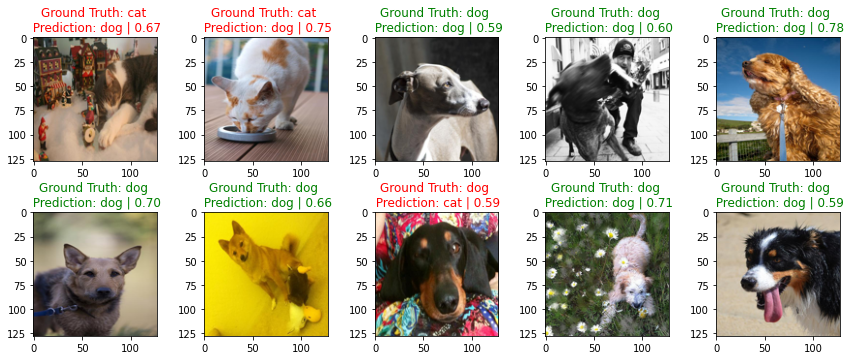

In [ ]:
# Plot 10 prediction results
y_pred_label = lr_pipeline.predict(X_test)
y_pred_label_proba = lr_pipeline.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(12,5))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

#### RandomForest pipeline model with Normalizer

Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 26
	predictor__max_features: 3
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 300

To avoid overfitting, we choose max_depth with 5.

In [ ]:
# Define RandomForest pipeline with Normalizer
rf_pipeline = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("RandomForest", RandomForestClassifier(
                         bootstrap=False, max_depth=5, max_features=3,
                          min_samples_leaf=3, min_samples_split=15,
                          n_estimators=300, n_jobs=-1, random_state=42))
                     ])

# model.fit and evaluation
rf_pipeline.fit(X_train, y_train)
trainAcc  = rf_pipeline.score(X_train, y_train)
validAcc  = rf_pipeline.score(X_valid, y_valid)
testAcc  = rf_pipeline.score(X_test, y_test_label)

# results
results_2.loc[1] = [f"RandomForest pipeline", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "RandomForest pipeline with Normalizer"]
results_2

Pipeline  ...                                  Description
0  LogisticRegression pipeline  ...  LogisticRegression pipeline with Normalizer
1        RandomForest pipeline  ...        RandomForest pipeline with Normalizer

[2 rows x 5 columns]

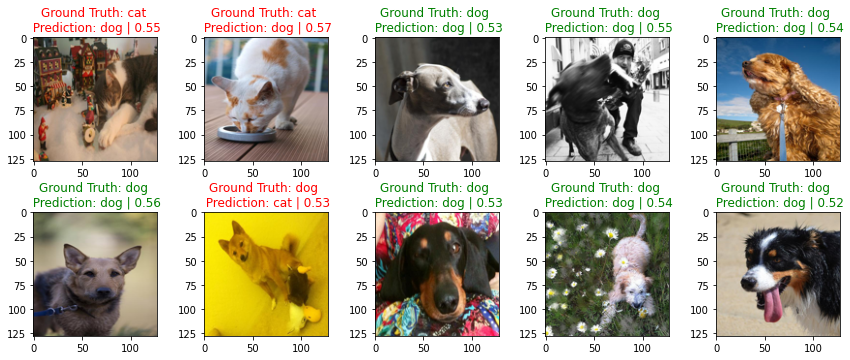

In [ ]:
# Plot 10 prediction results
y_pred_label = rf_pipeline.predict(X_test)
y_pred_label_proba = rf_pipeline.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(12,5))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

#### Naive Bayes pipeline model with Normalizer

In [ ]:
# Define Naive Bayes pipeline with Normalizer
nb_pipeline = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("Naive Bayes", GaussianNB())
                     ])

# model.fit and evaluation
nb_pipeline.fit(X_train, y_train)
trainAcc  = nb_pipeline.score(X_train, y_train)
validAcc  = nb_pipeline.score(X_valid, y_valid)
testAcc  = nb_pipeline.score(X_test, y_test_label)

# results
results_2.loc[2] = [f"Naive Bayes pipeline", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "Naive Bayes pipeline with Normalizer"]
results_2

Pipeline  ...                                  Description
0  LogisticRegression pipeline  ...  LogisticRegression pipeline with Normalizer
1        RandomForest pipeline  ...        RandomForest pipeline with Normalizer
2         Naive Bayes pipeline  ...         Naive Bayes pipeline with Normalizer

[3 rows x 5 columns]

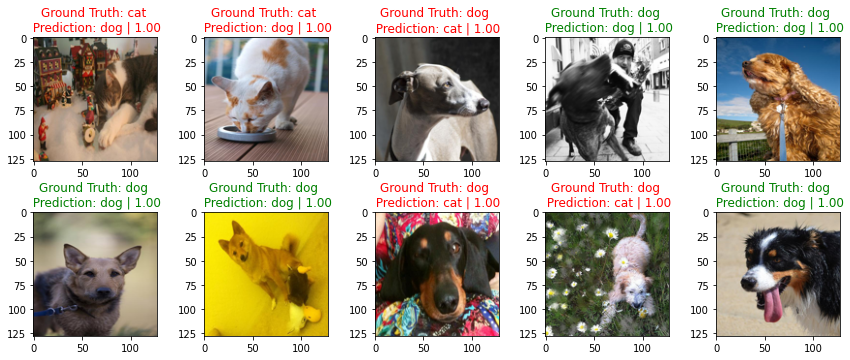

In [ ]:
# Plot 10 prediction results
y_pred_label = nb_pipeline.predict(X_test)
y_pred_label_proba = nb_pipeline.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(12,5))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

#### SVC pipeline model with Normalizer

Best Parameters:
	predictor__C: 10
	predictor__degree: 1
	predictor__kernel: rbf

In [ ]:
# Define SVC pipeline with Normalizer
svc_pipeline = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("SVC", SVC(C=10, kernel='rbf', degree=1, random_state=42))
                     ])

# model.fit and evaluation
svc_pipeline.fit(X_train, y_train)
trainAcc  = svc_pipeline.score(X_train, y_train)
validAcc  = svc_pipeline.score(X_valid, y_valid)
testAcc  = svc_pipeline.score(X_test, y_test_label)

# results
results_2.loc[3] = [f"SVC pipeline", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "SVC pipeline with Normalizer"]
results_2

Pipeline  ...                                  Description
0  LogisticRegression pipeline  ...  LogisticRegression pipeline with Normalizer
1        RandomForest pipeline  ...        RandomForest pipeline with Normalizer
2         Naive Bayes pipeline  ...         Naive Bayes pipeline with Normalizer
3                 SVC pipeline  ...                 SVC pipeline with Normalizer

[4 rows x 5 columns]

#### Results

1. Test accuracy are 56.4%, 55.98%, and 54.05% for RandomForest, LogisticRegression, and Naive Bayes respectively.
2. RandomForest pipeline performed better than LogisticRegression pipeline and Naive Bayes.
3. Although SVC is time-consuming, we trained the model and lt took 5 hours to run. We found SVC pipeline model showed the test accuracy is 60.83%, which is better than LogisticRegression, RandomForest and Naive Bayes pipelines.
4. SVC model showed high train accuracy (99.94%). It was overfitting. We need to tune the hyperparameters to reduce overfitting.


## Bounding boxes regression modeling

### Hyperparameter tuning and regression algorithms comparison


We build a baseline classification model and use GridSearch to find best parameters for different models. We compare the model performances to determine which model we can use for further modeling.

#### Define functions and load data

In [ ]:
# imports
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from time import time
from scipy import stats
import json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
results = pd.DataFrame(columns=["ExpID", "Cross fold train MSE", "Test MSE", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# load data
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split data to generate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.1, random_state=27)
# subset of image data
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=27)

#### Baseline linear regression model

In [ ]:
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("linear", LinearRegression())])

with tf.device('/gpu:0'):

    start = time()
    full_pipeline_with_predictor.fit(X_train, y_train)
    np.random.seed(42)

    # Set up cross validation scores, Use ShuffleSplit() with 30 splits, 30% test_size 
    cv30Splits = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
    cv_results = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv30Splits, scoring = 'neg_mean_squared_error')  

    trainMSE = cv_results.mean()
    train_time = np.round(time() - start, 4)

    # Time and score test predictions
    start = time()
    y_test_pred  = full_pipeline_with_predictor.predict(X_test)
    testMSE = mean_squared_error(y_test, y_test_pred)
    test_time = np.round(time() - start, 4)

results.loc[0] = ["Baseline", -trainMSE, np.round(testMSE,3), 
                  "---", train_time, test_time, "Untuned LinearRegression"]
results

ExpID  Cross fold train MSE  Test MSE p-value  Train Time(s)  \
0  Baseline              0.017517     0.018     ---       572.3439   

   Test Time(s)    Experiment description  
0         0.189  Untuned LinearRegression

#### Grid search for best paremeters with different linear regression algorithms

In [ ]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Linear Regression', LinearRegression()),
        ('Lasso Regression', Lasso(random_state = 42)),
        ('Ridge Regression', Ridge(random_state = 42)),
        ('Elastic Net', ElasticNet(random_state = 42)),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Linear Regression': {},
        
        'Lasso Regression': {
            'tol': (0.0001, 0.00001, 0.0000001), 
            "alpha":(.0001, .001, .01, .05, .1, .5)
        },
        
        'Ridge Regression' : {
            'tol': (0.0001, 0.00001, 0.0000001), 
            "alpha":(.0001, .001, .01, .05, .1, .5)
        },
        
        'Elastic Net': {
            'tol': (0.0001, 0.00001, 0.0000001),
            "alpha":(.0001, .001, .01, .05, .1, .5),
            'l1_ratio': (.15,  .50)
        },
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ('scaler', StandardScaler()),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='neg_mean_squared_error', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = grid_search.best_score_

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_MSE = mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test))
        test_time = round(time() - start, 4)

        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv30Splits, scoring = 'neg_mean_squared_error')
        best_train_MSE = best_train_scores.mean()
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(cv_results, best_train_scores)

        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()                                            
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, -best_train_MSE, best_test_MSE, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [ ]:
%%time
with tf.device('/gpu:0'):
    ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  n_jobs=-1, verbose=2)

****** START Best Model: Linear Regression *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.6s remaining:   37.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s finished


Best Parameters:
****** FINISH Best Model: Linear Regression  *****

****** START Best Model: Lasso Regression *****
Parameters:
	alpha: (0.0001, 0.001, 0.01, 0.05, 0.1, 0.5)
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 42.7min finished


Best Parameters:
	predictor__alpha: 0.01
	predictor__tol: 1e-07
****** FINISH Best Model: Lasso Regression  *****

****** START Best Model: Ridge Regression *****
Parameters:
	alpha: (0.0001, 0.001, 0.01, 0.05, 0.1, 0.5)
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


Best Parameters:
	predictor__alpha: 0.5
	predictor__tol: 0.0001
****** FINISH Best Model: Ridge Regression  *****

****** START Best Model: Elastic Net *****
Parameters:
	alpha: (0.0001, 0.001, 0.01, 0.05, 0.1, 0.5)
	l1_ratio: (0.15, 0.5)
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 97.4min finished


Best Parameters:
	predictor__alpha: 0.05
	predictor__l1_ratio: 0.15
	predictor__tol: 0.0001
****** FINISH Best Model: Elastic Net  *****

Wall time: 2h 27min 17s


In [ ]:
results

ExpID  Cross fold train MSE  Test MSE  p-value  \
0                      Baseline              0.017517  0.018000      ---   
1  Best Model:Linear Regression              0.017522  0.018201  0.48748   
2   Best Model:Lasso Regression              0.010004  0.010003  0.00044   
3   Best Model:Ridge Regression              0.017490  0.018191   0.4751   
4        Best Model:Elastic Net              0.009989  0.010009  0.00054   

   Train Time(s)  Test Time(s)  \
0       572.3439         0.189   
1        23.2241         0.499   
2        20.9015         0.161   
3         2.9138         0.124   
4        12.2286         0.149   

                              Experiment description  
0                           Untuned LinearRegression  
1                                                 []  
2  [["predictor__alpha", 0.01], ["predictor__tol"...  
3  [["predictor__alpha", 0.5], ["predictor__tol",...  
4  [["predictor__alpha", 0.05], ["predictor__l1_r...

#### Results

1. Ridge showed similar cross fold train MSE compared with baseline model (cross fold MSE: 0.01749 compared to 0.017517, p-value: 0.4751>0.05).
2. Both Lasso and ElasticNet models had a significant better performance compared to baseline model (cross fold train MSE: 0.010004 and 0.009989 respectively, p-values: 0.00044 and 0.00054 respectively)



### Feature engineering comparison using linear regression

#### Load data

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

# Load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

# Set up reporting
results_3 = pd.DataFrame(columns=["Pipeline", "Train MSE", "Valid MSE", "Test MSE", "Description"])

X train           shape: (8816, 49152)
X validation      shape: (2205, 49152)
X test            shape: (1945, 49152)


#### Define feture engineering function

In [ ]:
# Define function for feature extraction of bounding box data
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# Define functions to calculate w and h
def bbox_trans1(dataset):
    y_bbox[:,2] = y_bbox[:,2] - y_bbox[:,0] 
    y_bbox[:,2]
    return dataset

def bbox_trans2(dataset):
    y_bbox[:,3] = y_bbox[:,3] - y_bbox[:,1] 
    y_bbox[:,3]
    return dataset

# make data pipeline
data_pipeline = Pipeline([
     ("CalculatedColumn_w", DataframeFunctionTransformer(bbox_trans1)),
     ("CalculatedColumn_h", DataframeFunctionTransformer(bbox_trans2)),
     ('Normalizer', Normalizer())
])

# test data pipeline function
data_tt = data_pipeline.fit_transform(y_bbox)
data_tt

array([[0.15203151, 0.24724282, 0.6806865 , 0.67262423],
       [0.        , 0.        , 0.54645175, 0.83749056],
       [0.08708629, 0.05144331, 0.47858757, 0.87219465],
       ...,
       [0.00128676, 0.0369941 , 0.860799  , 0.50759715],
       [0.        , 0.02706426, 0.7199188 , 0.6935304 ],
       [0.12011232, 0.05731186, 0.6904554 , 0.71102726]], dtype=float32)

#### No feature engineering with baseline linear regression

In [ ]:
# Baseline linear regression model to predict the bounding box
lr_regression_pipe = make_pipeline(
          #data_pipeline,
          LinearRegression()
          )

# model.fit and evaluation
lr_regression_pipe.fit(X_train, y_train)

# calculate MSE
trainMSE  = mean_squared_error(y_train, lr_regression_pipe.predict(X_train))
validMSE  = mean_squared_error(y_valid, lr_regression_pipe.predict(X_valid))
testMSE  = mean_squared_error(y_test, lr_regression_pipe.predict(X_test))

# ExperimentLog
# results
results_3.loc[0] = [f"Linear Regression pipeline", f"{trainMSE:8.5f}", 
                   f"{validMSE:8.5f}", f"{testMSE:8.5f}",
                   "Linear Regression pipeline with no feature engineering"]
results_3

Pipeline  ...                                        Description
0  Linear Regression pipeline  ...  Linear Regression pipeline with no feature eng...

[1 rows x 5 columns]

#### Feature engineering with linear regression model

In [ ]:
# Now we combine this preprocessing step based on the ColumnTransformer with a
# regression in a Pipeline to predict the bounding box 
lr_regression_pipe = make_pipeline(
          data_pipeline,
          LinearRegression()
          )

# model.fit and evaluation
lr_regression_pipe.fit(X_train, y_train)

# calculate MSE
trainMSE  = mean_squared_error(y_train, lr_regression_pipe.predict(X_train))
validMSE  = mean_squared_error(y_valid, lr_regression_pipe.predict(X_valid))
testMSE  = mean_squared_error(y_test, lr_regression_pipe.predict(X_test))

# results
results_3.loc[1] = [f"Linear Regression pipeline", f"{trainMSE:8.5f}", 
                   f"{validMSE:8.5f}", f"{testMSE:8.5f}",
                   "Linear Regression pipeline with feature engineering"]
results_3

Pipeline  ...                                        Description
0  Linear Regression pipeline  ...  Linear Regression pipeline with no feature eng...
1  Linear Regression pipeline  ...  Linear Regression pipeline with feature engine...

[2 rows x 5 columns]

#### Results

Use column transfer bbox[XMin, YMin, XMax, YMax] to bbox[x, y, w, h] did not improve the model performance (test MSE is 0.0323 compared to 0.03064)

### SKLearn model for bounding boxes regression using feature engineering

#### ElasticNet pipeline model with feature engineering

In [ ]:
 # Now we can combine this preprocessing step based on the ColumnTransformer with a
 # regression in a Pipeline to predict the bounding box of the cat or the dog
ElasticNet_pipe = make_pipeline(
          data_pipeline,
          ElasticNet(alpha = 0.05, tol = 0.0001, l1_ratio = 0.15)
          )

 # model.fit and evaluation
ElasticNet_pipe.fit(X_train, y_train)

trainMSE  = mean_squared_error(y_train, ElasticNet_pipe.predict(X_train))
validMSE  = mean_squared_error(y_valid, ElasticNet_pipe.predict(X_valid))
testMSE  = mean_squared_error(y_test, ElasticNet_pipe.predict(X_test))

results_3.loc[2] = [f"ElasticNet pipeline", f"{trainMSE:8.5f}", 
                   f"{validMSE:8.5f}", f"{testMSE:8.5f}",
                   "ElasticNet pipeline with feature engineering and best parameters"]
results_3

Pipeline  ...                                        Description
0  Linear Regression pipeline  ...  Linear Regression pipeline with no feature eng...
1  Linear Regression pipeline  ...  Linear Regression pipeline with feature engine...
2         ElasticNet pipeline  ...  ElasticNet pipeline with feature engineering a...

[3 rows x 5 columns]

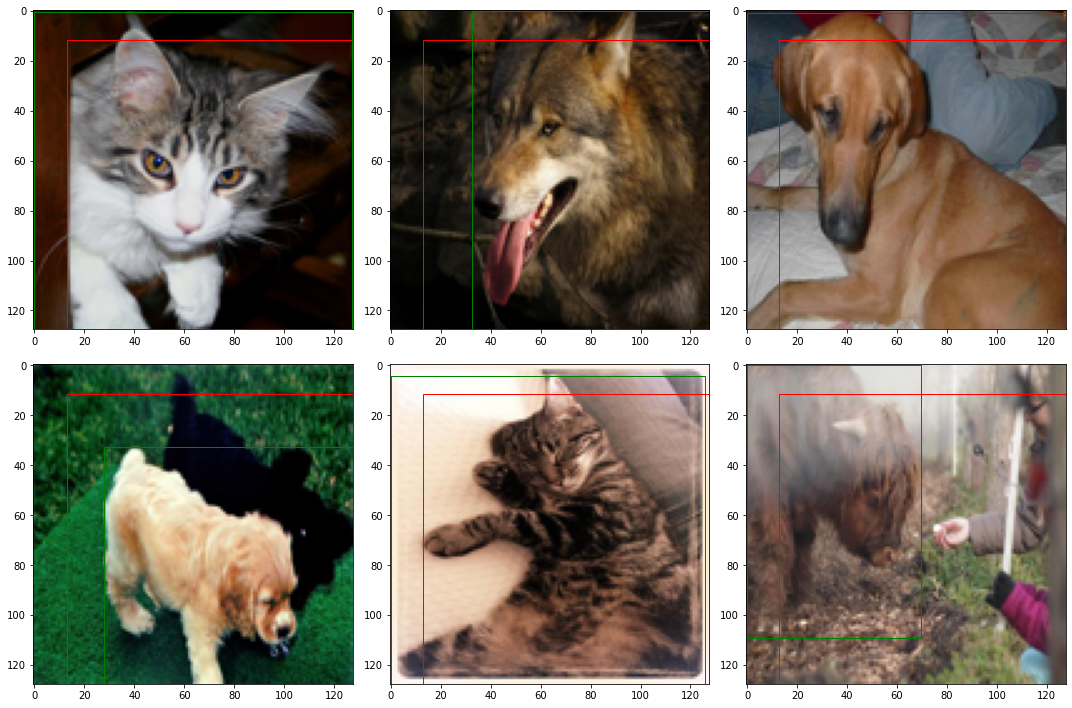

In [ ]:
y_test_pred = ElasticNet_pipe.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    train_box = y_test[j] * 128
    test_box = y_test_pred[j] * 128
    ax[i].imshow(X_test[j].reshape(128,128,3))
    ax[i].add_patch(plt.Rectangle((test_box[0], test_box[1]), test_box[2], test_box[3], edgecolor='red', facecolor='none'))
    ax[i].add_patch(plt.Rectangle((train_box[0], train_box[1]), train_box[2], train_box[3], edgecolor='green', facecolor='none'))

plt.tight_layout()
plt.show()

#### Results

ElasticNet pipeline with best paremeters and feature engineering can improve the linear regression performance (Test MSE is 0.01033 compared with 0.03064 in linear regression baseline model).

# Test model performances using the filtered dataset

## Generation of the filtered dataset





### Sort bounding box dataset

In [ ]:
# load bounding box dataset
df = pd.read_csv('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv')
# Remove Truncated, Occluded and depiction images - impproves the accuracy of model training
# Might decrease precision and sensitivity for dataset with truncated , occluded and depicted images.
df = df[df.IsTruncated==0]
df = df[df.IsOccluded==0]
df = df[df.IsDepiction==0]
df

ImageID     Source  LabelName  ...  XClick2Y  XClick3Y  XClick4Y
4      00064d23bf997652     xclick  /m/0bt9lr  ...  0.370000  0.424286  0.694286
18     0020c297db8672b8     xclick  /m/0bt9lr  ...  0.514620  0.903091  0.656642
49     0060b2fad4ef55d1     xclick  /m/0bt9lr  ...  0.620000  0.158333  0.402500
80     009b71cc4fd38230     xclick  /m/0bt9lr  ...  0.625263  0.300000  0.444211
127    0104ed24ce594848     xclick  /m/0bt9lr  ...  0.960000  0.446250  0.597500
...                 ...        ...        ...  ...       ...       ...       ...
12945  ff3dd2b204a39a42     xclick   /m/01yrx  ...  0.413125  0.100000  0.337500
12946  ff451d4fc378e028  activemil   /m/01yrx  ... -1.000000 -1.000000 -1.000000
12953  ff9ceca28231f6fa  activemil   /m/01yrx  ... -1.000000 -1.000000 -1.000000
12955  ffa777d9064123b1     xclick   /m/01yrx  ...  0.447423  0.686598  0.668041
12960  ffc08e87dabfb85a     xclick   /m/01yrx  ...  0.827500  0.663125  0.120000

[1365 rows x 21 columns]

### Re-scale images

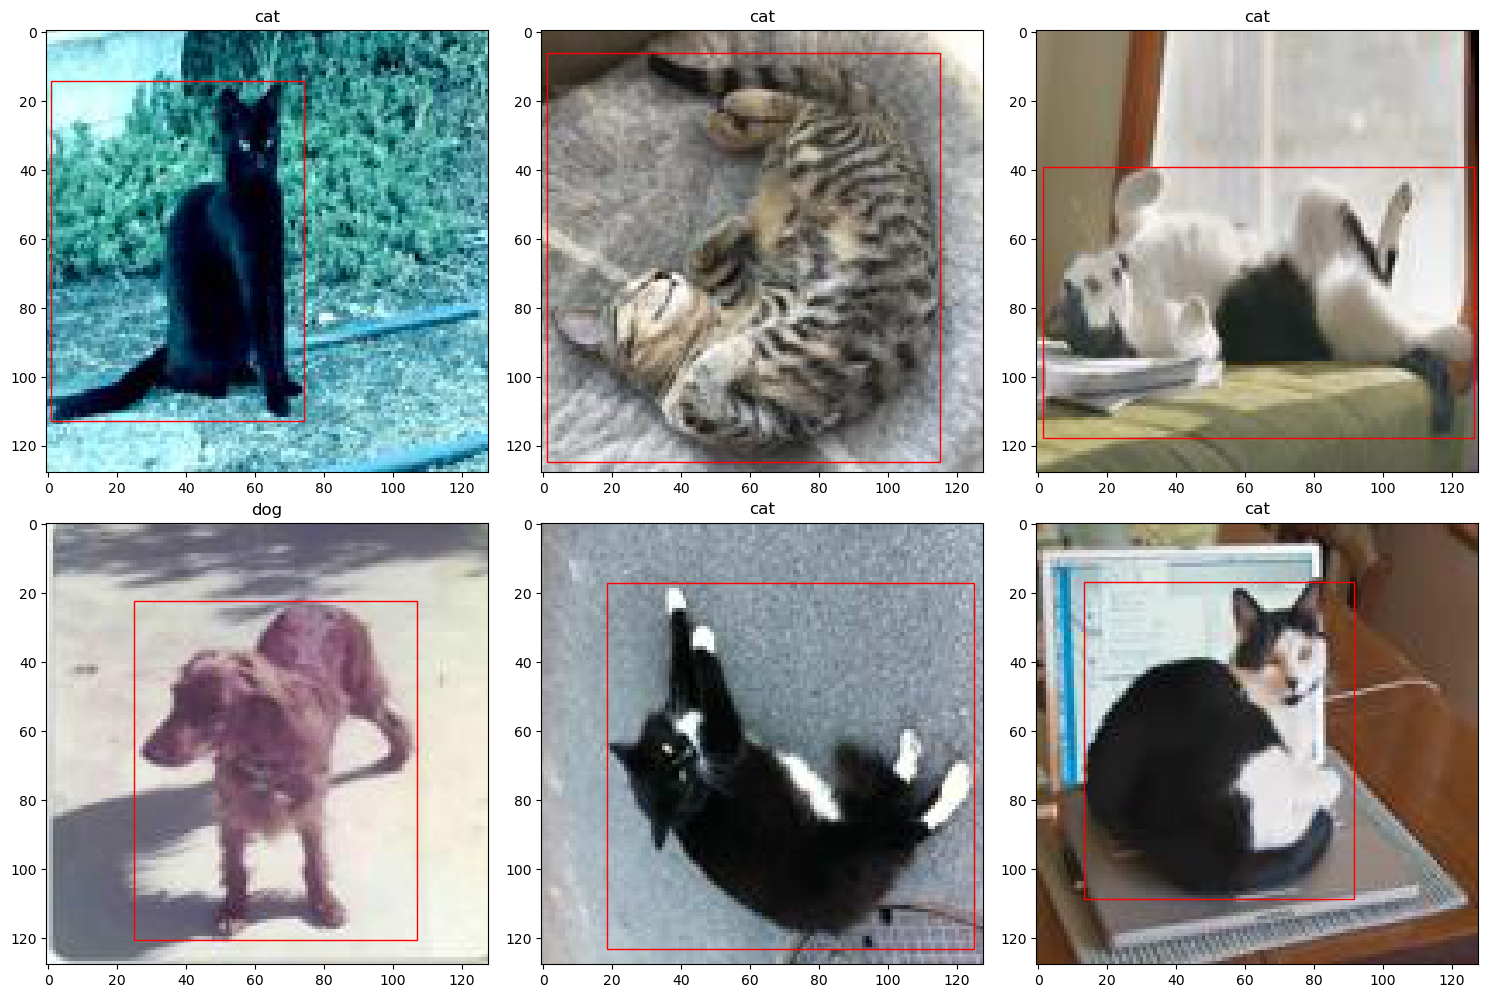

In [ ]:
# rescale images
%%time
path = 'images/'
img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

# plot random 6 re-scaled images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### Encode labels and save filtered dataset

In [ ]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

# save filtered images
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img_filtered.npy', img_arr.astype(np.uint8))
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label_filtered.npy', df.Label.values)
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data//y_bbox_filtered.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

## Use the filtered dataset to train SKLearning models

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

# Set up reporting
results_4 = pd.DataFrame(columns=["Pipeline", "Train Acc", "Valid Acc", "Test Acc", "Description"])

X train           shape: (873, 49152)
X validation      shape: (219, 49152)
X test            shape: (273, 49152)


### Random Forest model for image *classification*

Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 26
	predictor__max_features: 3
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 300

To avoid overfitting, we choose max_depth with 5.

#### Using the whole dataset

In [ ]:
# Load un-filtered data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (8297, 49152)
X validation      shape: (2075, 49152)
X test            shape: (2594, 49152)


In [ ]:
# Define RandomForest pipeline with Normalizer
rf_pipeline2 = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("RandomForest", RandomForestClassifier(
                         bootstrap=False, max_depth=5, max_features=3,
                          min_samples_leaf=3, min_samples_split=15,
                          n_estimators=300, n_jobs=-1, random_state=42))
                     ])

# model.fit and evaluation
rf_pipeline2.fit(X_train, y_train)
trainAcc  = rf_pipeline2.score(X_train, y_train)
validAcc  = rf_pipeline2.score(X_valid, y_valid)
testAcc  = rf_pipeline2.score(X_test, y_test_label)

# results
results_4.loc[0] = [f"RandomForest", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "Using the whole dataset"]
results_4

X train           shape: (8297, 49152)
X validation      shape: (2075, 49152)
X test            shape: (2594, 49152)


Pipeline  Train Acc  Valid Acc   Test Acc              Description
0  RandomForest     63.76%     54.89%     56.40%  Using the whole dataset

#### Using the filtered dataset

In [ ]:
# Load filtered data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img_filtered.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label_filtered.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox_filtered.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

In [ ]:
# Define RandomForest pipeline with Normalizer
rf_pipeline3 = Pipeline([
                     ("Normalizer", Normalizer()),
                     ("RandomForest", RandomForestClassifier(
                         bootstrap=False, max_depth=5, max_features=3,
                          min_samples_leaf=3, min_samples_split=15,
                          n_estimators=300, n_jobs=-1, random_state=42))
                     ])

# model.fit and evaluation
rf_pipeline3.fit(X_train, y_train)
trainAcc  = rf_pipeline3.score(X_train, y_train)
validAcc  = rf_pipeline3.score(X_valid, y_valid)
testAcc  = rf_pipeline3.score(X_test, y_test_label)

# results
results_4.loc[1] = [f"RandomForest + filtered dataset", f"{trainAcc*100:8.2f}%", 
                   f"{validAcc*100:8.2f}%", f"{testAcc*100:8.2f}%",
                   "Using the filtered dataset"]
results_4

X train           shape: (873, 49152)
X validation      shape: (219, 49152)
X test            shape: (273, 49152)


Pipeline  ...               Description
0                   RandomForest  ...   Using the whole dataset
1  RandomForest + Sorted dataset  ...  Using the sorted dataset

[2 rows x 5 columns]

### ElasticNet model for bounding box regression

Best Parameters:
	predictor__alpha: 0.05
	predictor__l1_ratio: 0.15
	predictor__tol: 0.0001

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

# Define function for feature extraction of bounding box data
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# Define functions to calculate w and h
def bbox_trans1(dataset):
    y_bbox[:,2] = y_bbox[:,2] - y_bbox[:,0] 
    y_bbox[:,2]
    return dataset

def bbox_trans2(dataset):
    y_bbox[:,3] = y_bbox[:,3] - y_bbox[:,1] 
    y_bbox[:,3]
    return dataset

# make data pipeline
data_pipeline = Pipeline([
     ("CalculatedColumn_w", DataframeFunctionTransformer(bbox_trans1)),
     ("CalculatedColumn_h", DataframeFunctionTransformer(bbox_trans2)),
     ('Normalizer', Normalizer())
])

# Set up reporting
results_5 = pd.DataFrame(columns=["Pipeline", "Train MSE", "Valid MSE", "Test MSE", "Description"])

#### Using the whole dataset

In [ ]:
# Load whole dataset
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (8816, 49152)
X validation      shape: (2205, 49152)
X test            shape: (1945, 49152)


In [ ]:
 # Now we can combine this preprocessing step based on the ColumnTransformer with a
 # regression in a Pipeline to predict the bounding box of the cat or the dog
ElasticNet_pipe = make_pipeline(
          data_pipeline,
          ElasticNet(alpha = 0.05, tol = 0.0001, l1_ratio = 0.15)
          )

 # model.fit and evaluation
ElasticNet_pipe.fit(X_train, y_train)

trainMSE  = mean_squared_error(y_train, ElasticNet_pipe.predict(X_train))
validMSE  = mean_squared_error(y_valid, ElasticNet_pipe.predict(X_valid))
testMSE  = mean_squared_error(y_test, ElasticNet_pipe.predict(X_test))

results_5.loc[0] = [f"ElasticNet + Whole dataset", f"{trainMSE:8.5f}", 
                   f"{validMSE:8.5f}", f"{testMSE:8.5f}",
                   "ElasticNet using whole dataset with feature engineering and best parameters"]
results_5

Pipeline  ...                                        Description
0  ElasticNet + Whole dataset  ...  ElasticNet using whole dataset with feature en...

[1 rows x 5 columns]

#### Using the filtered dataset

In [ ]:
# Load filtered data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img_filtered.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label_filtered.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox_filtered.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (873, 49152)
X validation      shape: (219, 49152)
X test            shape: (273, 49152)


In [ ]:
# Define RandomForest pipeline with Normalizer
ElasticNet_pipe = make_pipeline(
          data_pipeline,
          ElasticNet(alpha = 0.05, tol = 0.0001, l1_ratio = 0.15)
          )

 # model.fit and evaluation
ElasticNet_pipe.fit(X_train, y_train)

trainMSE  = mean_squared_error(y_train, ElasticNet_pipe.predict(X_train))
validMSE  = mean_squared_error(y_valid, ElasticNet_pipe.predict(X_valid))
testMSE  = mean_squared_error(y_test, ElasticNet_pipe.predict(X_test))

results_5.loc[1] = [f"ElasticNet + filtered dataset", f"{trainMSE:8.5f}", 
                   f"{validMSE:8.5f}", f"{testMSE:8.5f}",
                   "Using filtered dataset with feature engineering and best parameters"]
results_5

Pipeline  ...                                        Description
0   ElasticNet + Whole dataset  ...  ElasticNet using whole dataset with feature en...
1  ElasticNet + Sorted dataset  ...  Using sorted dataset with feature engineering ...

[2 rows x 5 columns]

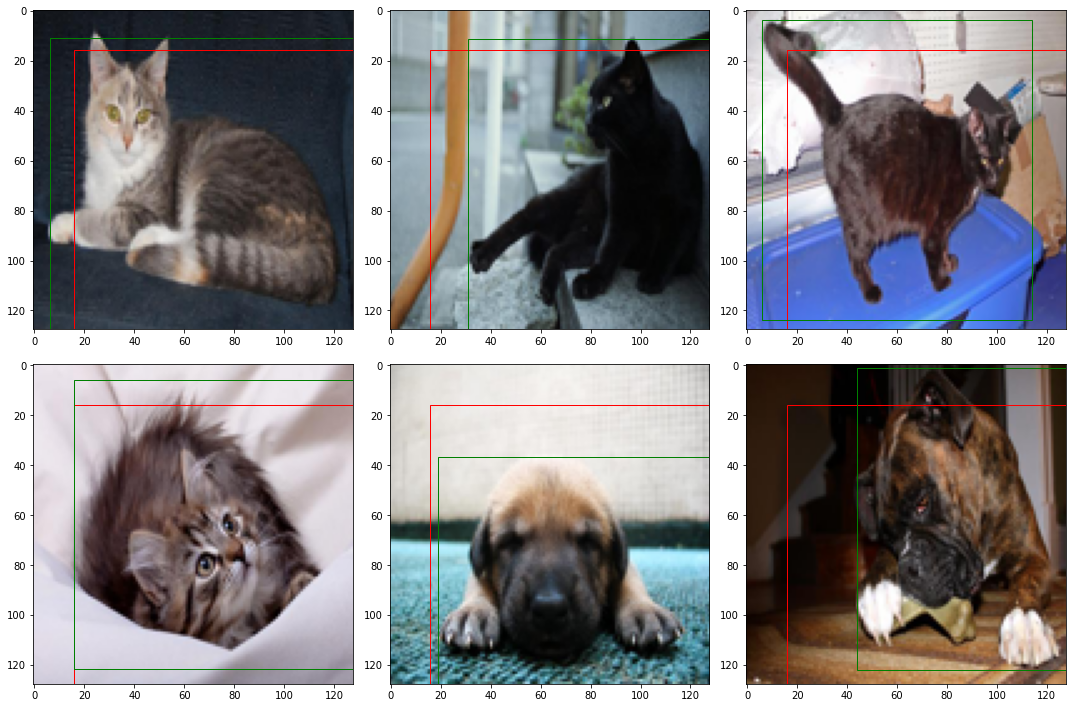

In [ ]:
y_test_pred = ElasticNet_pipe.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    train_box = y_test[j] * 128
    test_box = y_test_pred[j] * 128
    ax[i].imshow(X_test[j].reshape(128,128,3))
    ax[i].add_patch(plt.Rectangle((test_box[0], test_box[1]), test_box[2], test_box[3], edgecolor='red', facecolor='none'))
    ax[i].add_patch(plt.Rectangle((train_box[0], train_box[1]), train_box[2], train_box[3], edgecolor='green', facecolor='none'))

plt.tight_layout()
plt.show()

### Results

1.   We filtered the dataset by data feature selection (NotTruncated, NotOccluded, and NotDepiction).

2.   Using the filtered dataset can dramatically improve the performance of Random Forest model. The test accuracy showed a great improvement from 56.40% to 72.16%. 

3.   It can also improved the ElasticNet linear regression model. The test MSE decreased from 0.01033 to 0.00730.



# Homegrown cat/dog detector pipeline 

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

In [ ]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings

In [ ]:
path = 'images/'

In [ ]:
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)

# Scaling X
X = X.astype(np.float32) / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.7, random_state=27, stratify=y_label)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=0.95, random_state=27, stratify=y_test)

In [ ]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc",
                               "Test  Acc",
                               "Train CXE",
                               "Test  CXE",
                               "Train MSE",
                               "Test  MSE"
                              ])

## Baseline Logistic Regression model

In [ ]:
# import warnings
# warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def cross_entropy(y, h):
        return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

exp_name = f"Built-in Logistic Regression"
expLog.loc[0,:] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict_proba(X_train)[:, 1].round()), 
                accuracy_score(y_test, model.predict_proba(X_test)[:, 1].round()),
                cross_entropy(y_train, model.predict_proba(X_train)[:, 1]),
                cross_entropy(y_test, model.predict_proba(X_test)[:, 1]),
                mean_squared_error(y_train, model.predict_proba(X_train)[:, 1]),
                mean_squared_error(y_test, model.predict_proba(X_test)[:, 1])],3))


expLog

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


exp_name Train Acc Test  Acc Train CXE Test  CXE  \
0  Built-in Logistic Regression       1.0     0.528     0.004       NaN   

  Train MSE Test  MSE  
0       0.0     0.416

## Homegrown Logistic Regression model

In [ ]:
class LogisticRegressionHG:
    def __init__(self, X, learning_rate=0.0001, num_iters=1000):
        self.lr = learning_rate
        self.num_iters = num_iters

        # m for #training_examples, n for #features
        self.m, self.n = X.shape

    def fit(self, X, y):
        
        y = np.reshape(y, (y.shape[0], 1))
        
        # init weights
        self.weights = np.zeros((self.n, 1))
        self.bias = 0

        for it in range(self.num_iters + 1):
            # calculate hypothesis
            y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
#             print(y_predict.shape)

            # calculate cost
            cost = [(-1/ self.m * np.sum(y * np.log(y_predict + 10**-8) + (1 - y) * np.log(1 - y_predict + 10**-8))),
                    mean_squared_error(y, y_predict)]

            # back prop / gradient calculations
#             print((y).shape)
            dw = 1 / self.m * np.dot(X.T, (y_predict - y))
            db = 1 / self.m * np.sum(y_predict - y)

            # gradient descent update step
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # print cost sometimes
            if it % 100 == 0:
                print(f"After iteration {it}:- CXE: {cost[0]}\t CXE+MSE: {cost[0] + cost[1]}")

        return self.weights, self.bias

    def predict(self, X):
        y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
        y_predict_labels = y_predict > 0.5

        return y_predict

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [ ]:
model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegressionHG(X_train))])
w, b = model.fit(X_train, y_train)

exp_name = "Homegrown Logistic Regression"

X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)
expLog.loc[1,:] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, X_train_pred.round()), 
                accuracy_score(y_test, X_test_pred.round()),
                cross_entropy(y_train, X_train_pred),
                cross_entropy(y_test, X_test_pred),
                mean_squared_error(y_train, X_train_pred),
                mean_squared_error(y_test, X_test_pred)],3))

expLog

After iteration 0:- CXE: 0.6931471605599454	 CXE+MSE: 0.9431471605599454
After iteration 100:- CXE: 0.6729795831947175	 CXE+MSE: 0.91305143286426
After iteration 200:- CXE: 0.6651661930993504	 CXE+MSE: 0.9014617986617603
After iteration 300:- CXE: 0.6589375741333011	 CXE+MSE: 0.8922374896796814
After iteration 400:- CXE: 0.6535153111158347	 CXE+MSE: 0.8842175554158027
After iteration 500:- CXE: 0.648621454376956	 CXE+MSE: 0.8769871199771128
After iteration 600:- CXE: 0.6441175350775884	 CXE+MSE: 0.8703396623625155
After iteration 700:- CXE: 0.6399222361264977	 CXE+MSE: 0.8641539689356006
After iteration 800:- CXE: 0.6359818245917153	 CXE+MSE: 0.8583499179931606
After iteration 900:- CXE: 0.6322576631034975	 CXE+MSE: 0.852869829941822
After iteration 1000:- CXE: 0.6287203272925758	 CXE+MSE: 0.8476697059137455


exp_name Train Acc Test  Acc Train CXE Test  CXE  \
0   Built-in Logistic Regression       1.0     0.528     0.004       NaN   
1  Homegrown Logistic Regression      0.66     0.559     0.719     0.719   

  Train MSE Test  MSE  
0       0.0     0.416  
1     0.219     0.245

## Results

1. The homegrown logistic regression model had a better performance on the test set with 55.9% accuracy compared to sklearn's regression model which had a 52.8% accuracy on the test set.
2. The cross-entropy loss function was implemented, along with a custom loss function that adds CXE and Mean Squared Error (MSE) together.
3. The models were built in the form of a pipeline where first the data was scaled using StandardScaler, and then was fed into the model for training.

# Results and discussion

## EDA

There are a total of 12966 images and the total size is 844.512 MB. In these images, 6855 are from dog and 6111 are from cat. Almost half of the images are occluded by another object in the image. There are 9578 images which extend beyond the boundary of the images. There are 180 images in which the box spans a group of objects. There are 592 images in which the box spans a group of objects. Descriptive statistics of bounding box data shows the mean, std, range of the data. Distribution of image shapes shows that they vary from 384X384 to 512X384. Distribution of image sizes shows that they are normally distributed. We need rescale the image shapes for modeling. 


## Preprocessing

We rescaled the images into the size of 128X128X3. We also encode image labels into numbers (dog:1, cat:0). We saved image data and bounding box data into array datasets. We double-checked the datasets by loading the data and plot some random images.

## Modeling pipelines

### Image classification model pipelines


  We built a baseline classification model and used GridSearch to find best parameters for different models. We compared the model performances (cross fold train accuracy) to determine which model we can use for further modeling. We found that: 1) SVC had the best cross fold train accuracy (56.2%). However, the train time was too long for modeling. 2) LogisticRegression, RandomForest, and Naive Bayes had a relatively better performances and is less time-consuming. We used these algorithms for further modeling.

  Several preprocessing methods can be used for image data. Normalize samples individually to unit norm. MinMaxScaler transform features by scaling each feature to a given range. We also determined which transformation methods perform best with logistic regression. Standardize features by removing the mean and scaling to unit variance. We found that: 1) Normalier had the highest test accuracy compared to baseline (test accuracy is 55.7%, p value is 0.02514). 2) StandardScaler and MinMaxScaler have similar test accuracy compared to baseline (52.7% and 53.2% compared to 53.4%). We chose Normalier for further modeling. 

  We combined Logistic Regression, Random Forest, and Naive Bayes with Normalier for SKLearn pipeline modeling. Test accuracy were 56.4%, 55.98%, and 54.05% for Random Forest, Logistic Regression, and Naive Bayes respectively. Random Forest pipeline showed the best performance compared to Logistic Regression pipeline and Naive Bayes. Although SVC is time-consuming, we trained the model and lt took 5 hours to run. We found SVC pipeline model showed the test accuracy is 60.83%, which is better than LogisticRegression, RandomForest and Naive Bayes pipelines. SVC model showed high train accuracy (99.94%). It was overfitting. We need to tune the hyperparameters to reduce overfitting.


### Bounding box regression model pipelines

Ridge showed similar Cross fold train MSE compared with baseline model (Cross fold train MSE: 0.01749 comparred to 0.010004, p-value: 0.4751>0.05). Both Lasso and ElasticNet models had a significant better performance compared to baseline model (Cross fold train MSE: 0.010004 and 0.0099989 respectively, p-values: 0.00044 and 0.00054 respectively).Use column transfer bbox[XMin, YMin, XMax, YMax] to bbox[x, y, w, h] did not improve the model performance (test MSE is 0.0323 compared to 0.03064). ElasticNet pipeline with best paremeters and feature engineering can improve the linear regression performance (Test MSE is 0.01033 compared with 0.03064 in linear regression baseline model).

### Test model performances using filtered dataset

We filtered the dataset by data feature selection (NotTruncated, NotOccluded, and NotDepiction). Using the filtered dataset can dramatically improve the performance of Random Forest model. The test accuracy showed a great improvement from 56.40% to 72.16%. It can also improved the ElasticNet linear regression model. The test MSE decreased from 0.01033 to 0.00730.

## Homegrown logistic regression model

  The homegrown logistic regression model had a better performance on the test set with 55.9% accuracy compared to sklearn's regression model which had a 52.8% accuracy on the test set. The cross-entropy loss function was implemented, along with a custom loss function that adds CXE and Mean Squared Error (MSE) together. The models were built in the form of a pipeline where first the data was scaled using StandardScaler, and then was fed into the model for training.

  


## Discussion

Overall, our classification models showed about 50-60% test accuracies. SVC pipeline model showed the best test accuracy than other classifier models. However, its train accuracy is about 99.94% which means the model is overfitting. We need try more parameters to reduce overfitting of the SVC model. Using column to transfer bbox[XMin, YMin, XMax, YMax] to bbox[x, y, w, h] did not improve the performances of our regression models. We need to performance more feature engineering methods to improve our models. Principal component analysis (PCA) is a technique for reducing the dimensionality of image datasets, increasing interpretability but at the same time minimizing information loss. We will try these methods to reduce the training time and to increase the accuracy. By using the filtered dataset, we can dramatically improve the performances of our models. However, the filtered dataset only contains 1365 images. In the future, we will use data augmentation to increase the dataset size to get better model training results. 

# Conclusion and next steps


The focus of our project is to build models that can accurately differentiate between cats and dogs, and indicate the position of the animal in the image using bounding boxes. While Logistic Regression and Linear Regression can be used to detect class and predict boxes respectively, we needed to experiment with different models and perform hyper-parameter tuning to identify the best models.

In this phase, we performed exploratory data analysis to understand the data, built baseline models to compare our performance, built multiple sklearn models with best parameters through grid search, and also built a homegrown logistic regression model with CXE and CXE + MSE as the loss functions along with regularization. We also used a filtered dataset by data feature selection to improve our models. SVC obtained the highest accuracy for image classification whereas Linear Regression with elastic net showed the best performance for bounding boxes. 

In the future, we plan to implement transfer learning for detection of classes, and fine-tune the model using EfficientNet D0-D7. We also plan to implement a neural network model to improve the performance for detecting classes and predicting bounding boxes.